In [110]:
import psycopg2
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
% matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data_cleaning.create_staging_tables import create_staging_legislator_df_STEP_ONE, create_staging_bill_df_STEP_THREE

#### features to create:
* rep_score DONE
* minority_score
* num_sponsors DONE
* date_introduced
* type_dummies
* bill_length


#### features to clean:
* sponsor_agency DONE

In [2]:
engine = create_engine('postgresql://localhost:5432/wa_leg_raw')

In [5]:
raw_bill_df = pd.read_sql_query('select * from "bill_api"', con=engine)
raw_sponsor_df = pd.read_sql_query('select * from "sponsor_api"', con=engine)
raw_vote_df = pd.read_sql_query('select * from "vote_api"', con=engine)
raw_committee_member_df = pd.read_sql_query('select * from "committee_member_api"', con=engine)
missing_leg_info_df = pd.read_csv('../data/missing_legislators.csv', sep = '|')
raw_sponsor_df = pd.read_sql_query('select * from "sponsor_api"', con=engine)

In [34]:
legislator_df = create_staging_legislator_df_STEP_ONE(raw_vote_df, raw_committee_member_df, missing_leg_info_df)

In [55]:
legislator_df['party'] = legislator_df['party'].apply(change_party_word_to_int)

In [14]:
bill_df = create_staging_bill_df_STEP_THREE(raw_bill_df, raw_sponsor_df)

/Users/emilykarboski/galvanize/washington_state_legislation/data_cleaning/create_staging_tables.py:372: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sponsor_df_reformatted['bill_num'] = sponsor_df_reformatted['bill_id'].apply(lambda x: x.split()[1])
/Users/emilykarboski/galvanize/washington_state_legislation/data_cleaning/create_staging_tables.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sponsor_df_reformatted['bill_num_unique'] = sponsor_df_reformatted['biennium'] + ' ' + sponsor_df_reformatted['bill_num']


In [54]:
def change_party_word_to_int(party):
        if party == 'Democrat':
            return 0
        if party == 'Republican':
            return 1

In [64]:
minority_df = pd.read_csv('../data/party_minority_history.csv', sep='|')

In [67]:
minority_df.head()

,agency,biennium,minority_party
0,Senate,1991-92,D
1,House,1991-92,R
2,Senate,1993-94,R
3,House,1993-94,R
4,Senate,1995-96,R


In [ ]:
def create_final_bill_df(staging_bill_df, raw_vote_df):
    """Creates a dataframe with all bills and bill info including a column labeling whether the bill has
    been voted on or not. This dataframe will be used to model whether a bill will make it to a vote."""
    
    raw_vote_df['bill_unique'] = raw_vote_df['biennium'] + ' ' + raw_vote_df['bill_id']
    bills_already_voted_on = raw_vote_df['bill_unique'].unique()
    
    def determine_if_reached_vote(bill_unique):
        if bill_unique in bills_already_voted_on:
            return True
        return False
    
    def filter_out_old_versions(row):
        count = len(bill_df[bill_df['bill_num_unique'] == row['bill_num_unique']])
        if count > 1 and row['reached_vote'] == False:
            return False
        return True
    
    def count_sponsors(secondary_sponsors):
        """Counts secondary sponsors, adding one for the primary sponsors"""
        if type(secondary_sponsors) == list:
            return len(secondary_sponsors) + 1
        else: return 1
        
    def change_agency_to_int(agency):
        if agency == 'House':
            return 0
        if agency == 'Senate':
            return 1
        
    def create_bill_rep_score(row):
        '''Return # of republican sponsors / total sponsors. If there are no secondary sponsors return -1 so that
        later, when this table is joined with merged_final, the primary sponsor party can fill this field.'''
        sponsors = row['secondary_sponsors']
        if type(sponsors) == list:
            sponsors.append(row['primary_sponsor_id'])

            sponsor_parties = []
            for s in sponsors:
                subset_leg = legislator_df[legislator_df['id'] == int(s)]
                if len(subset_leg) > 0:
                    sponsor_party = sum(subset_leg.iloc[:, 4]) / len(subset_leg)
                    sponsor_parties.append(sponsor_party)
            bill_rep_score = np.mean(sponsor_parties)
            return bill_rep_score
        else:
            subset_leg = legislator_df[legislator_df['id'] == int(row['primary_sponsor_id'])]
            primary_sponsor_party = sum(subset_leg.iloc[:, 4]) / len(subset_leg)
            return primary_sponsor_party
    
    def change_rep_score_to_minority_score(row):
        if row['sponsor_agency'] == 0:
            subset = minority_df[(minority_df['biennium'] == row['biennium']) & (minority_df['agency'] == 'House')]  
        if row['sponsor_agency'] == 1:
            subset = minority_df[(minority_df['biennium'] == row['biennium']) & (minority_df['agency'] == 'Senate')]
        subset = subset.reset_index()
        minority_party = subset.loc[0, 'minority_party']
        if minority_party == 'D':
            return 1 - row['rep_score']
        if minority_party == 'Even':
            return 0
        return row['rep_score']
    
    def change_biennium_to_year_count(biennium):
        year = int(biennium[0:4])
        return year - 1991
    
    staging_bill_df['reached_vote'] = staging_bill_df['bill_unique'].apply(determine_if_reached_vote)
    staging_bill_df['is_final_version'] = staging_bill_df.apply(filter_out_old_versions, axis=1)
    bill_df = staging_bill_df[staging_bill_df['is_final_version'] == True]
    bill_df = bill_df.drop(['is_final_version', 'description', 'long_friendly_name', 'name', 
                            'htm_last_modified_date'], axis=1)
    bill_df['sponsor_agency'] = bill_df['sponsor_agency'].apply(change_agency_to_int)
    bill_df['num_sponsors'] = bill_df['secondary_sponsors'].apply(count_sponsors)
    bill_df['rep_score'] = bill_df.apply(create_bill_rep_score, axis=1)
    bill_df['minority_score'] = bill_df.apply(change_rep_score_to_minority_score, axis=1)
    bill_df['year_count'] = bill_df['biennium'].apply(change_biennium_to_year_count)
    
    return bill_df

In [151]:
bill_df.head()

,biennium,bill_id,class,htm_create_date,htm_url,type,bill_unique,bill_num,bill_num_unique,sponsor_agency,primary_sponsor_id,secondary_sponsors,reached_vote,num_sponsors,rep_score,year_count
1,1991-92,SHB 1001,Bills,1991-02-01T00:00:00,http://app.leg.wa.gov/documents/billdocs/1991-...,House Bills,1991-92 SHB 1001,1001,1991-92 1001,0,251,"[444, 72, 34, 54, 48, 7, 481, 301, 478, 264, 2...",True,34,0.684211,0
2,1991-92,HB 1002,Bills,1991-01-14T00:00:00,http://app.leg.wa.gov/documents/billdocs/1991-...,House Bills,1991-92 HB 1002,1002,1991-92 1002,0,251,"[332, 474, 475, 219, 285, 227, 180, 110, 484, ...",False,18,0.388889,0
4,1991-92,SHB 1003,Bills,1991-02-21T00:00:00,http://app.leg.wa.gov/documents/billdocs/1991-...,House Bills,1991-92 SHB 1003,1003,1991-92 1003,0,311,"[474, 54, 110, 311]",True,4,0.250000,0
5,1991-92,HB 1004,Bills,1991-01-14T00:00:00,http://app.leg.wa.gov/documents/billdocs/1991-...,House Bills,1991-92 HB 1004,1004,1991-92 1004,0,311,"[475, 304, 110, 32, 54, 311]",False,6,0.666667,0
6,1991-92,HB 1005,Bills,1991-01-14T00:00:00,http://app.leg.wa.gov/documents/billdocs/1991-...,House Bills,1991-92 HB 1005,1005,1991-92 1005,0,311,"[23, 475, 311]",False,3,0.333333,0


In [213]:
type_dummies = pd.get_dummies(bill_df['type'])

In [227]:
bill_df_with_dummies = pd.concat([bill_df, type_dummies], axis=1)

In [340]:
train = bill_df_with_dummies[bill_df_with_dummies['year_count'] <= 20]
test = bill_df_with_dummies[bill_df_with_dummies['year_count'] > 20]

In [439]:
# X_train = train[['sponsor_agency', 'primary_sponsor_id', 'num_sponsors', 'rep_score', 'bill_num', 'year_count']]
# X_test = test[['sponsor_agency', 'primary_sponsor_id', 'num_sponsors', 'rep_score', 'bill_num', 'year_count']]
X_train = train.drop(['year_count', 'primary_sponsor_id', 'sponsor_agency', 'biennium', 'bill_id', 'class', 'htm_create_date', 'htm_url', 'type', 'bill_unique', 'bill_num_unique',
                     'secondary_sponsors', 'reached_vote'], axis=1)
X_test = test.drop(['year_count', 'primary_sponsor_id', 'sponsor_agency', 'biennium', 'bill_id', 'class', 'htm_create_date', 'htm_url', 'type', 'bill_unique', 'bill_num_unique',
                     'secondary_sponsors', 'reached_vote'], axis=1)
y_train = train['reached_vote']
y_test = test['reached_vote']

In [440]:
baseline_model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=600, max_depth=3, random_state=709, 
                                       verbose=1)
baseline_model.fit(X_train, y_train)
y_pred_b = (baseline_model.predict_proba(X_test))[:,1]

      Iter       Train Loss   Remaining Time 
         1           1.3329           12.92s
         2           1.3097           12.32s
         3           1.2885           12.13s
         4           1.2690           12.13s
         5           1.2512           12.17s
         6           1.2347           12.07s
         7           1.2195           11.98s
         8           1.2055           11.93s
         9           1.1926           12.00s
        10           1.1806           11.97s
        20           1.0998           11.85s
        30           1.0519           12.24s
        40           1.0164           12.05s
        50           0.9889           12.31s
        60           0.9683           12.25s
        70           0.9526           12.00s
        80           0.9404           11.99s
        90           0.9310           11.80s
       100           0.9230           11.64s
       200           0.8902            9.15s
       300           0.8800            6.78s
       40

In [441]:
log_loss(y_test, y_pred_b)

0.45011309771249575

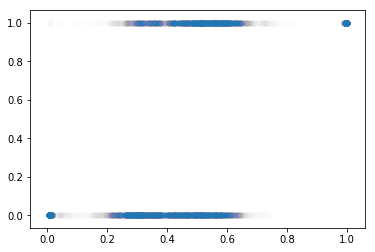

In [442]:
fig, ax = plt.subplots()
ax.scatter(y_pred_b, y_test, alpha=0.003)

In [443]:
roc_auc_b = roc_auc_score(y_test, y_pred_b)
fpr_b, tpr_b, thresholds_b = roc_curve(y_test, y_pred_b)

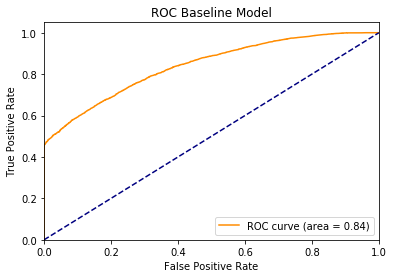

In [444]:
fig, ax = plt.subplots()
plt.plot(fpr_b, tpr_b, color='darkorange', label= f'ROC curve (area = {round(roc_auc_b, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Baseline Model')
plt.legend(loc="lower right")
plt.show()

In [445]:
features_importances = pd.DataFrame(baseline_model.feature_importances_, index=X_train.columns)
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [446]:
features_importances_sorted

,0
bill_num,0.374851
rep_score,0.189497
num_sponsors,0.151884
Session Laws,0.055946
House Passed Legislature,0.043665
Senate Passed Legislature,0.041901
Vetoes,0.035775
House Resolutions,0.032758
House Bills,0.022571
House Joint Resolutions,0.018916


In [447]:
len(X_train.columns)

17